# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [ ]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)
LC25000_test_data_au = data_augmentation(LC25000_test_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)
LC25000_test_data_au = np.array(LC25000_test_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)
print("The shape of LC25000_test_data: ", LC25000_test_data_au.shape)
print("The shape of LC25000_test_labels: " ,LC25000_test_labels.shape)

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


In [ ]:
import gc
gc.collect()

124

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_cyclegan_dir_train), "rb") as f:
    TCGA_cyclegan_train = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test), "rb") as f:
    TCGA_cyclegan_test = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_cyclegan_train['train']
TCGA_cyclegan_train_labels = TCGA_cyclegan_train['train_label']
TCGA_cyclegan_test_data = TCGA_cyclegan_test['test']
TCGA_cyclegan_test_labels = TCGA_cyclegan_test['test_label']

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (6400, 128, 128, 3)
The shape of TCGA_cyclegan_train_labels:  (6400,)
The shape of TCGA_cyclegan_test_data:  (6400, 128, 128, 3)
The shape of TCGA_cyclegan_test_labels:  (6400,)


In [ ]:
import gc
gc.collect()

250

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


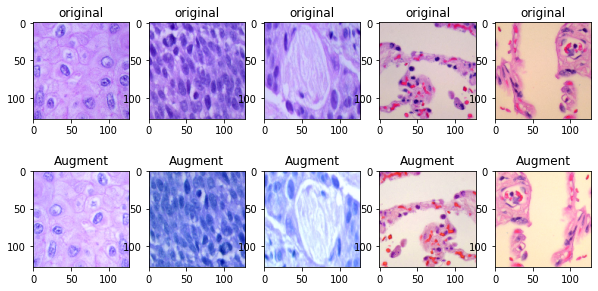

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

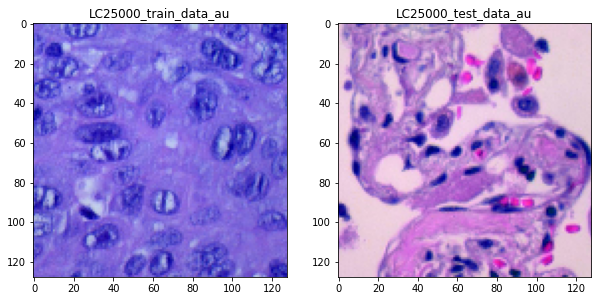

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data_au)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data_au")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data_au")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

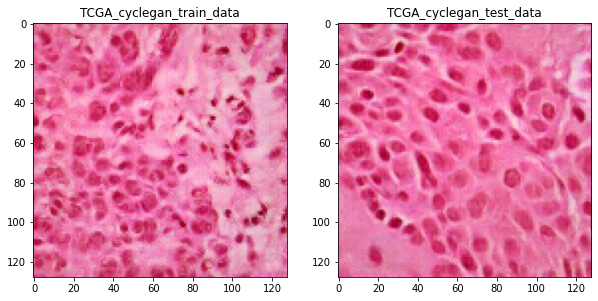

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - VGG

In [ ]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block_128.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block_128.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_cyclegan_train_lab = one.transform(np.array(TCGA_cyclegan_train_labels).reshape(-1, 1))

print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data_au (source) shape: (6400, 128, 128, 3)
TCGA_cyclegan_train_data (target) shape: (6400, 128, 128, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 4s 29ms/step - loss: 1.0882 - acc: 0.7794 - val_loss: 1.8645 - val_acc: 0.3584
Epoch 2/5
100/100 [==============================] - 2s 21ms/step - loss: 0.3372 - acc: 0.9017 - val_loss: 2.4460 - val_acc: 0.3009
Epoch 3/5
100/100 [==============================] - 2s 22ms/step - loss: 0.2323 - acc: 0.9261 - val_loss: 3.0835 - val_acc: 0.2445
Epoch 4/5
100/100 [==============================] - 2s 23ms/step - loss: 0.2195 - acc: 0.9294 - val_loss: 3.6428 - val_acc: 0.2114
Epoch 5/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2124 - acc: 0.9264 - val_loss: 4.0023 - val_acc: 0.1969
Epoch 1/100
100/100 [==============================] - 5s 34ms/step - loss: 0.1977 - acc: 0.9341 - val_loss: 3.0847 - val_acc: 0.2912
Epoch 2/100
100/100 [==============================] - 3s 29ms/step - loss: 0.1585 - acc: 0.9423 - val_loss: 3.8720 - val_acc: 0.2794
Epoch 3/100
100/100 [==============================] - 3s 29ms/step - lo

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 25ms/step - loss: 1.1903 - acc: 0.7680 - val_loss: 1.8537 - val_acc: 0.3356
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2840 - acc: 0.9116 - val_loss: 2.5985 - val_acc: 0.2920
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2283 - acc: 0.9280 - val_loss: 3.1298 - val_acc: 0.2594
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2331 - acc: 0.9252 - val_loss: 3.6899 - val_acc: 0.2055
Epoch 5/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2043 - acc: 0.9283 - val_loss: 3.8086 - val_acc: 0.2105
Epoch 1/100
100/100 [==============================] - 6s 35ms/step - loss: 0.1960 - acc: 0.9355 - val_loss: 3.3701 - val_acc: 0.2653
Epoch 2/100
100/100 [==============================] - 3s 29ms/step - loss: 0.1564 - acc: 0.9434 - val_loss: 3.9860 - val_acc: 0.2552
Epoch 3/100
100/100 [==============================] - 3s 29ms/step - lo

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 28ms/step - loss: 1.0429 - acc: 0.7970 - val_loss: 2.0846 - val_acc: 0.3025
Epoch 2/5
100/100 [==============================] - 2s 22ms/step - loss: 0.2823 - acc: 0.9133 - val_loss: 3.0037 - val_acc: 0.2734
Epoch 3/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2482 - acc: 0.9237 - val_loss: 3.6104 - val_acc: 0.2494
Epoch 4/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2146 - acc: 0.9292 - val_loss: 4.0998 - val_acc: 0.2317
Epoch 5/5
100/100 [==============================] - 2s 22ms/step - loss: 0.2055 - acc: 0.9291 - val_loss: 4.2843 - val_acc: 0.2298
Epoch 1/100
100/100 [==============================] - 4s 34ms/step - loss: 0.1957 - acc: 0.9344 - val_loss: 4.0912 - val_acc: 0.2584
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1561 - acc: 0.9439 - val_loss: 4.2372 - val_acc: 0.2875
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - lo

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 25ms/step - loss: 0.9817 - acc: 0.7952 - val_loss: 1.9413 - val_acc: 0.3455
Epoch 2/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2953 - acc: 0.9136 - val_loss: 2.5711 - val_acc: 0.3116
Epoch 3/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2303 - acc: 0.9287 - val_loss: 2.9327 - val_acc: 0.3070
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2308 - acc: 0.9270 - val_loss: 3.6011 - val_acc: 0.2452
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2018 - acc: 0.9278 - val_loss: 4.0480 - val_acc: 0.2313
Epoch 1/100
100/100 [==============================] - 4s 34ms/step - loss: 0.1967 - acc: 0.9372 - val_loss: 3.4208 - val_acc: 0.3027
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1632 - acc: 0.9433 - val_loss: 4.0647 - val_acc: 0.2798
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - lo

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 26ms/step - loss: 1.2958 - acc: 0.7619 - val_loss: 2.0853 - val_acc: 0.3900
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.3305 - acc: 0.9000 - val_loss: 2.4263 - val_acc: 0.3531
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2560 - acc: 0.9228 - val_loss: 3.0789 - val_acc: 0.2825
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2134 - acc: 0.9341 - val_loss: 3.3283 - val_acc: 0.2722
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2061 - acc: 0.9364 - val_loss: 3.5363 - val_acc: 0.2766
Epoch 1/100
100/100 [==============================] - 4s 34ms/step - loss: 0.1849 - acc: 0.9388 - val_loss: 3.5706 - val_acc: 0.2939
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1595 - acc: 0.9445 - val_loss: 3.6521 - val_acc: 0.3033
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Result

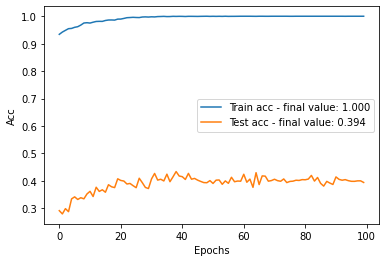

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


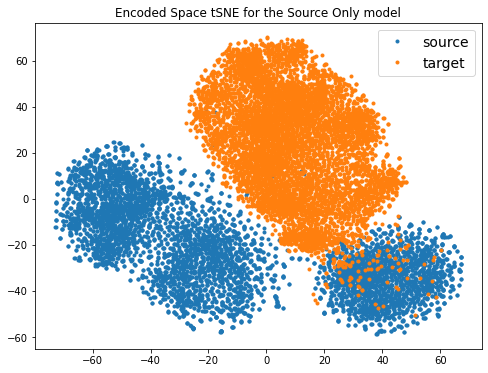

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.019454,0.993378,11.342294,0.390202
std,0.039544,0.013716,3.350742,0.029384
min,0.000003,0.934062,3.084681,0.279375
25%,0.000083,0.995430,8.834243,0.386250
50%,0.001018,0.999687,12.821537,0.398750
75%,0.013400,1.000000,14.092517,0.405430
max,0.197686,1.000000,15.066096,0.433750


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_source_VGG_128_RMS_0.5e-5_AU_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 48ms/step - loss: 0.7859 - acc: 0.7978 - disc_loss: 2.4025 - val_loss: 1.6579 - val_acc: 0.3303
Epoch 2/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2505 - acc: 0.9181 - disc_loss: 1.6574 - val_loss: 2.0525 - val_acc: 0.3247
Epoch 3/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2156 - acc: 0.9237 - disc_loss: 1.4226 - val_loss: 2.3324 - val_acc: 0.3400
Epoch 4/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1812 - acc: 0.9392 - disc_loss: 1.3036 - val_loss: 2.7666 - val_acc: 0.3398
Epoch 5/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1745 - acc: 0.9431 - disc_loss: 1.2259 - val_loss: 3.0415 - val_acc: 0.3598
Epoch 6/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1677 - acc: 0.9420 - disc_loss: 1.1702 - val_loss: 2.9558 - val_acc: 0.3889
Epoch 7/200
100/100 [==============================] - 4s 43ms/step - loss: 

### Run 2

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 11s 51ms/step - loss: 1.1175 - acc: 0.7473 - disc_loss: 2.2118 - val_loss: 1.6583 - val_acc: 0.2759
Epoch 2/200
100/100 [==============================] - 4s 44ms/step - loss: 0.2701 - acc: 0.9055 - disc_loss: 1.6173 - val_loss: 1.7624 - val_acc: 0.3470
Epoch 3/200
100/100 [==============================] - 4s 44ms/step - loss: 0.1926 - acc: 0.9359 - disc_loss: 1.3881 - val_loss: 2.2571 - val_acc: 0.3402
Epoch 4/200
100/100 [==============================] - 4s 44ms/step - loss: 0.1743 - acc: 0.9383 - disc_loss: 1.2519 - val_loss: 2.3531 - val_acc: 0.3678
Epoch 5/200
100/100 [==============================] - 4s 44ms/step - loss: 0.1656 - acc: 0.9425 - disc_loss: 1.1764 - val_loss: 2.5896 - val_acc: 0.3759
Epoch 6/200
100/100 [==============================] - 4s 44ms/step - loss: 0.1522 - acc: 0.9475 - disc_loss: 1.1293 - val_loss: 2.9679 - val_acc: 0.3750
Epoch 7/200
100/100 [==============================] - 4s 44ms/step - loss:

### Run 3

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 46ms/step - loss: 0.8446 - acc: 0.7950 - disc_loss: 2.6203 - val_loss: 1.6202 - val_acc: 0.3491
Epoch 2/200
100/100 [==============================] - 4s 41ms/step - loss: 0.2390 - acc: 0.9203 - disc_loss: 1.7090 - val_loss: 1.7130 - val_acc: 0.3945
Epoch 3/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1915 - acc: 0.9377 - disc_loss: 1.4546 - val_loss: 2.0771 - val_acc: 0.3900
Epoch 4/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1620 - acc: 0.9416 - disc_loss: 1.2658 - val_loss: 2.4282 - val_acc: 0.3869
Epoch 5/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1584 - acc: 0.9478 - disc_loss: 1.1889 - val_loss: 2.6863 - val_acc: 0.3920
Epoch 6/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1374 - acc: 0.9531 - disc_loss: 1.1404 - val_loss: 2.8257 - val_acc: 0.4023
Epoch 7/200
100/100 [==============================] - 4s 41ms/step - loss: 

### Run 4

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 47ms/step - loss: 0.8046 - acc: 0.7966 - disc_loss: 2.2985 - val_loss: 1.4982 - val_acc: 0.3522
Epoch 2/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2285 - acc: 0.9194 - disc_loss: 1.6292 - val_loss: 1.7975 - val_acc: 0.3683
Epoch 3/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1786 - acc: 0.9398 - disc_loss: 1.4109 - val_loss: 2.2043 - val_acc: 0.3628
Epoch 4/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1764 - acc: 0.9369 - disc_loss: 1.2699 - val_loss: 2.4832 - val_acc: 0.3642
Epoch 5/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1527 - acc: 0.9461 - disc_loss: 1.2063 - val_loss: 2.6740 - val_acc: 0.3825
Epoch 6/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1449 - acc: 0.9530 - disc_loss: 1.1783 - val_loss: 3.0787 - val_acc: 0.3816
Epoch 7/200
100/100 [==============================] - 4s 43ms/step - loss: 

### Run 5

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 50ms/step - loss: 0.0497 - acc: 0.9919 - disc_loss: 12.5260 - val_loss: 21.0416 - val_acc: 0.4861
Epoch 2/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1971 - acc: 0.9730 - disc_loss: 11.1637 - val_loss: 22.9053 - val_acc: 0.4792
Epoch 3/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1301 - acc: 0.9789 - disc_loss: 8.8133 - val_loss: 26.7882 - val_acc: 0.4705
Epoch 4/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0722 - acc: 0.9867 - disc_loss: 7.9494 - val_loss: 31.4862 - val_acc: 0.4658
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0928 - acc: 0.9837 - disc_loss: 7.4401 - val_loss: 31.1208 - val_acc: 0.4641
Epoch 6/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0827 - acc: 0.9844 - disc_loss: 7.2069 - val_loss: 31.7744 - val_acc: 0.4659
Epoch 7/200
100/100 [==============================] - 4s 42ms/step 

### Result

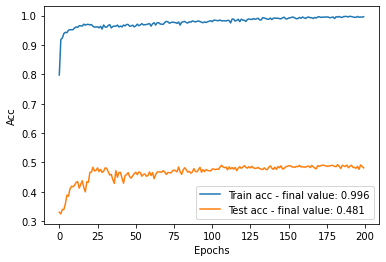

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


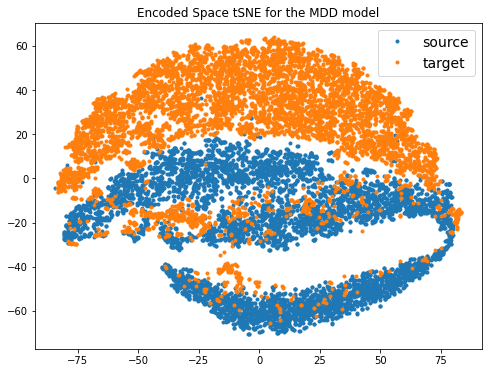

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.083418,0.978159,12.554944,8.809805,0.467835
std,0.072774,0.019188,3.856982,4.789871,0.028579
min,0.006859,0.797813,1.270560,1.657906,0.324688
25%,0.033610,0.968906,12.687582,4.702283,0.465586
50%,0.068616,0.980547,13.688225,7.827514,0.476562
75%,0.118846,0.991445,14.697196,12.457845,0.484414
max,0.785930,0.997813,16.500927,22.487900,0.492500


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD/MDD_VGG_RMS_0.5e-5_g1_AU_cyclegan.csv")

In [ ]:
import gc
gc.collect()

4091